In [30]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [31]:
data_url = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'

In [32]:
df = pd.read_csv(data_url, sep='\t')

In [33]:
df.columns

Index(['date', 'dosen_kumulativ', 'dosen_differenz_zum_vortag',
       'dosen_erst_differenz_zum_vortag', 'dosen_zweit_differenz_zum_vortag',
       'dosen_biontech_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_astrazeneca_kumulativ', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'impf_quote_erst', 'impf_quote_voll',
       'indikation_alter_dosen', 'indikation_beruf_dosen',
       'indikation_medizinisch_dosen', 'indikation_pflegeheim_dosen',
       'indikation_alter_erst', 'indikation_beruf_erst',
       'indikation_medizinisch_erst', 'indikation_pflegeheim_erst',
       'indikation_alter_voll', 'indikation_beruf_voll',
       'indikation_medizinisch_voll', 'indikation_pflegeheim_voll',
       'dosen_dim_kumulativ', 'dosen_kbv_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ',
       'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
       'dosen_astrazeneca_erst_kumulativ',
       'dos

In [34]:
df.date.iloc[-1]

'2021-06-04'

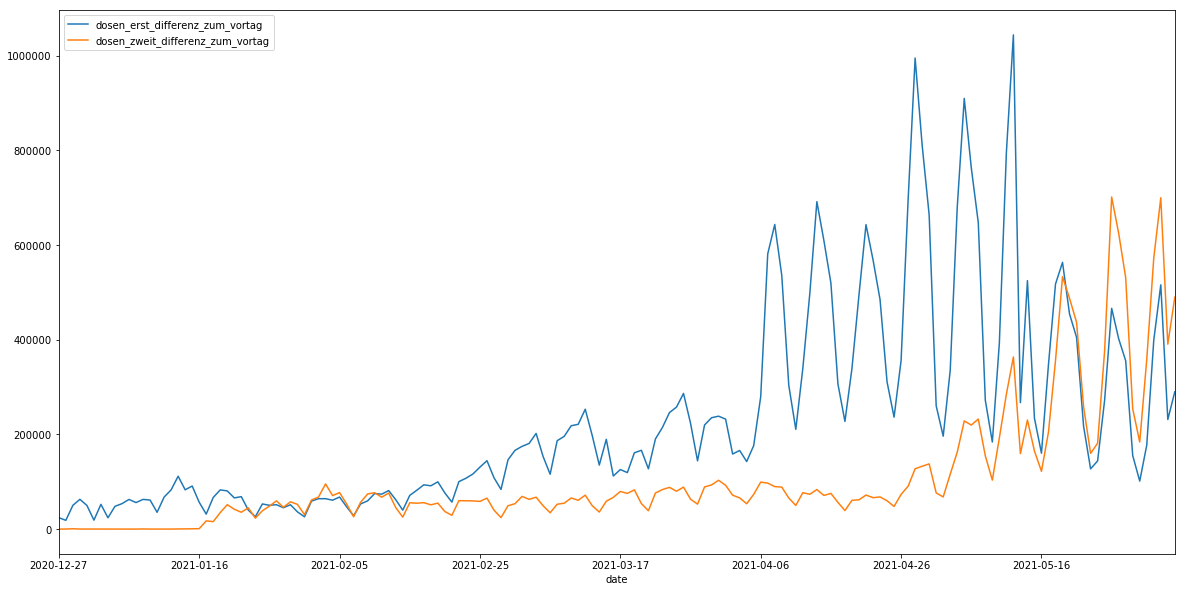

In [35]:
df.plot('date', ['dosen_erst_differenz_zum_vortag','dosen_zweit_differenz_zum_vortag'])
plt.show()

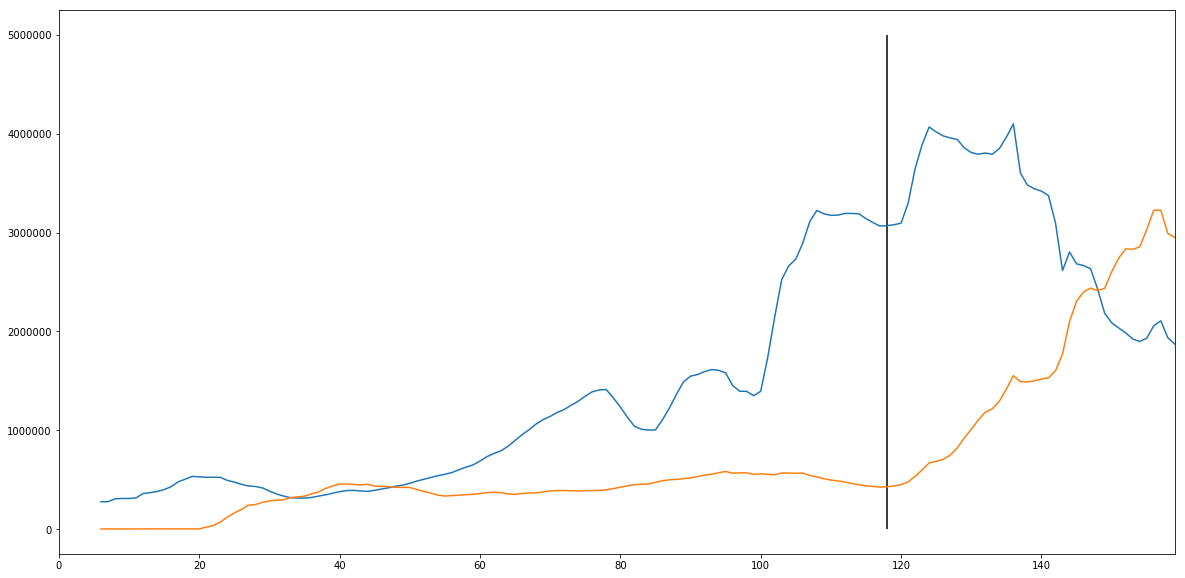

In [36]:
df['dosen_erst_differenz_zum_vortag'].rolling(7).sum().plot()
df['dosen_zweit_differenz_zum_vortag'].rolling(7).sum().plot()
plt.vlines(len(df) - 6*7, 0, 5e6)
plt.show()

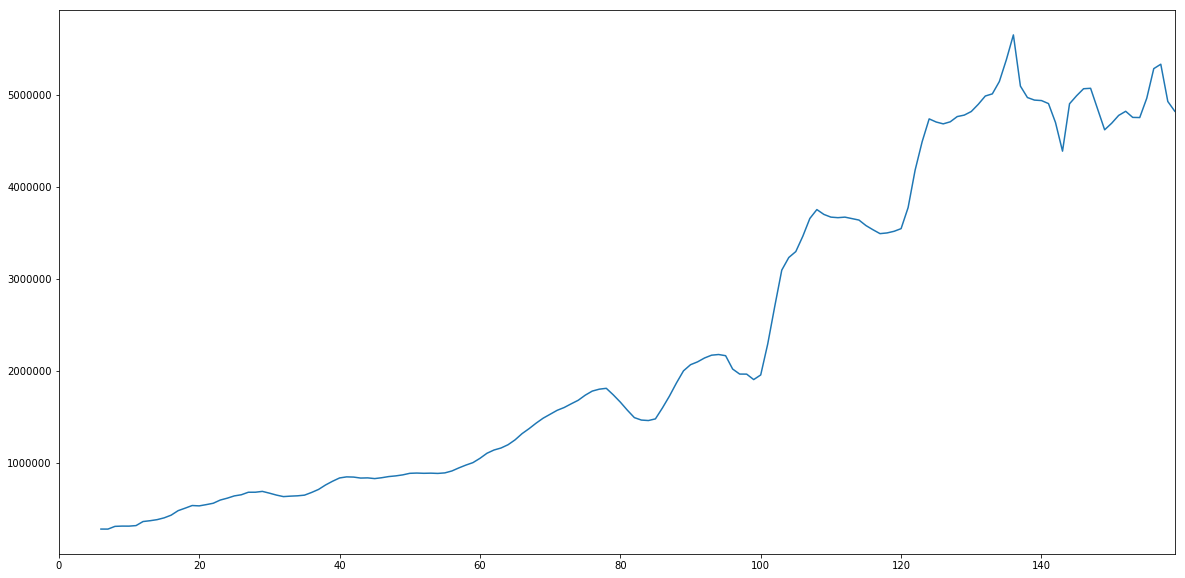

In [37]:
df['dosen_differenz_zum_vortag'].rolling(7).sum().plot()
plt.show()

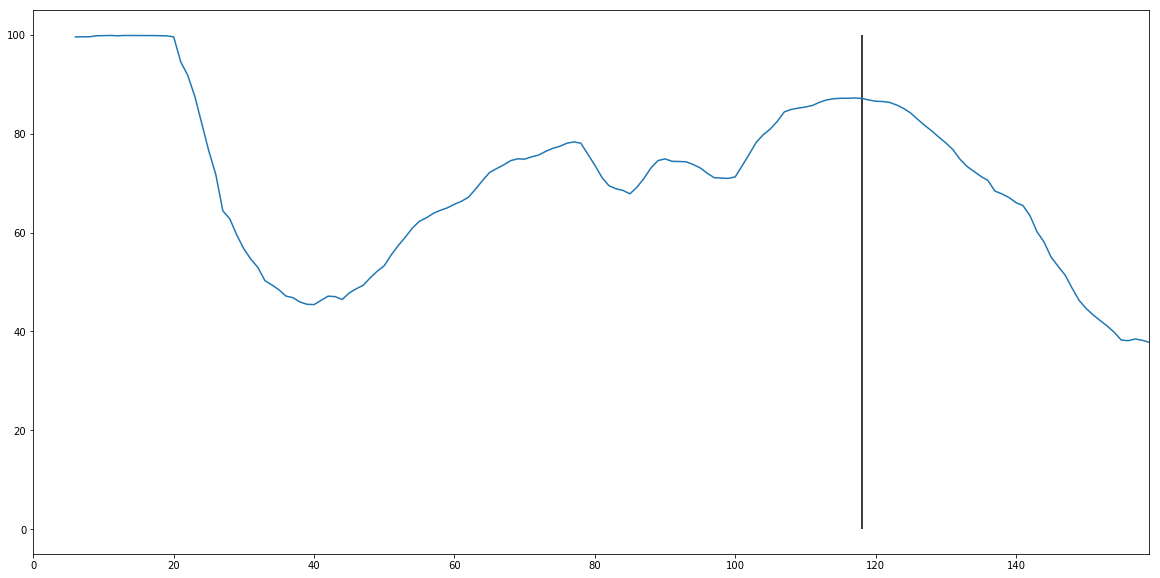

In [26]:
(100.0 * df.dosen_erst_differenz_zum_vortag / df.dosen_differenz_zum_vortag).rolling(7).mean().plot()
plt.vlines(len(df) - 6*7, 0, 100)
plt.show()

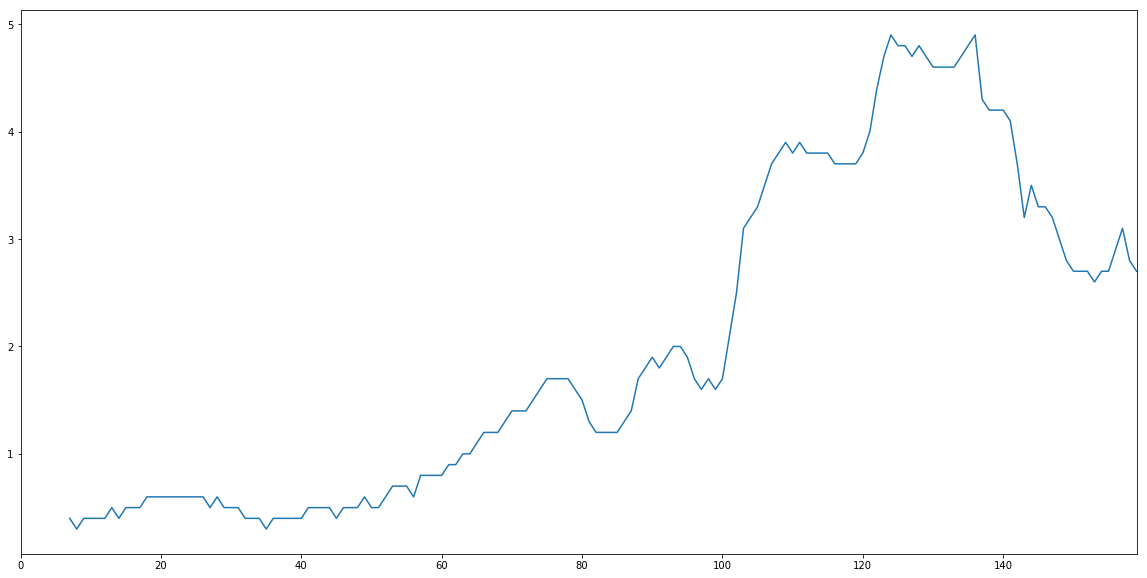

In [38]:
(df.impf_quote_erst.diff()*100.0).rolling(7).sum().plot()
plt.show()

In [39]:
(75.0 - df.impf_quote_erst.iloc[-1]*100.0)/((df.impf_quote_erst.diff()*100.0).rolling(7).sum().iloc[-1])

10.962962962963012

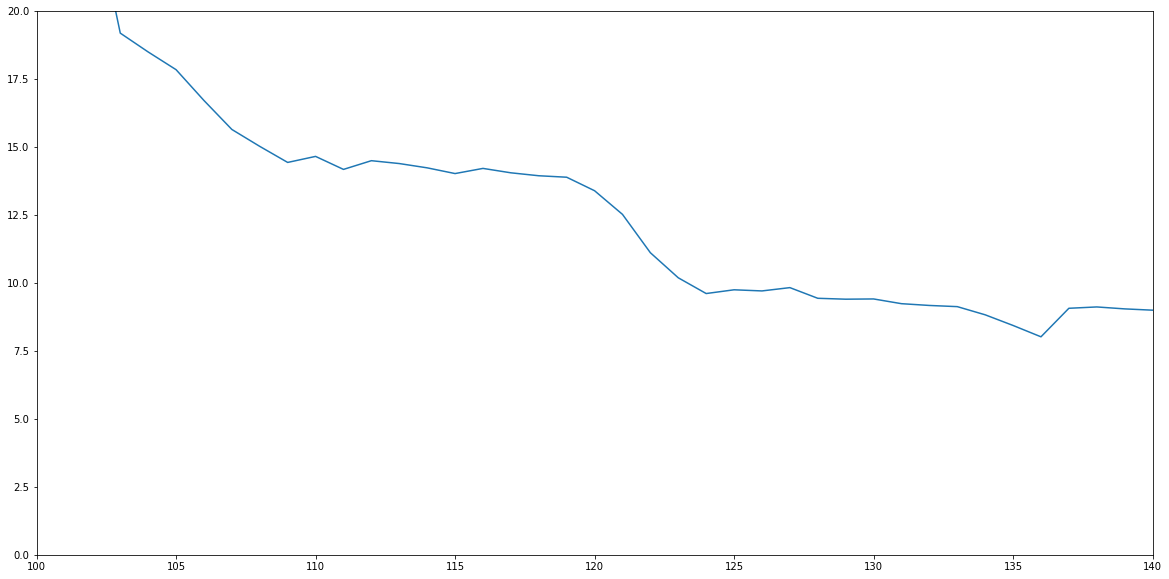

In [40]:
((75.0 - df.impf_quote_erst * 100.0)/((df.impf_quote_erst.diff()*100.0).rolling(7).sum())).plot()
plt.xlim(100,140)
plt.ylim(0,20)
plt.show()